In [1]:
import pandas as pd 
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from adjustText import adjust_text
from matplotlib import gridspec
%matplotlib inline

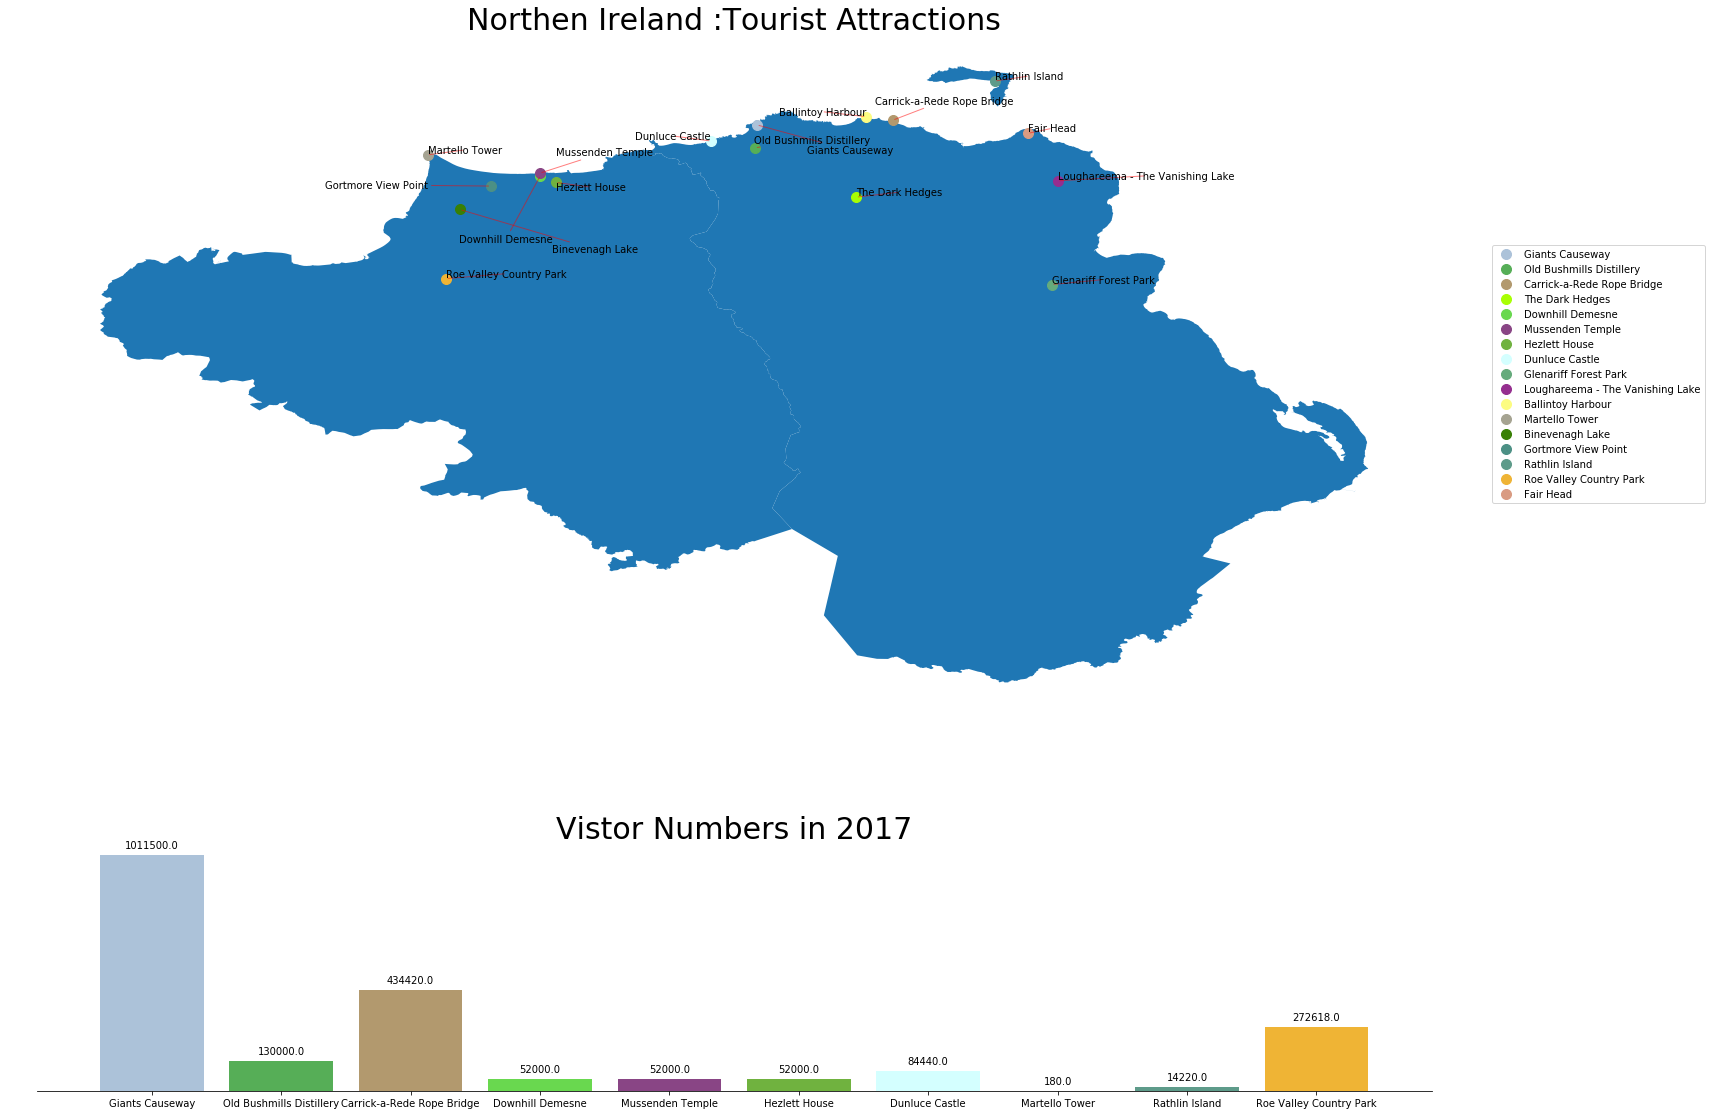

In [7]:
#getting the shp and location files 
tourist_df = gpd.read_file("Places_to_Visit_in_Causeway_Coast_and_Glens.geojson")
map_df = gpd.read_file("Shapefile\OSNI_Open_Data_Largescale_Boundaries__County_Boundaries.shp")

#getting rid of unneeded cols
tourist_df = tourist_df.iloc[:17,:]
map_df = map_df.drop([0,3,5,2])
tourist_df["Norm_data"] = tourist_df["Name"].str.upper()

# Getting vistor numbers for each attractions


data_sheet1 = pd.read_excel('Visitor-Attraction-Survey-2017-Additional-Tables-Charts.xls',skiprows=3,skipfooter=4,usecols=[2,9], sheet_name="sheet1")
data_sheet2 = pd.read_excel('Visitor-Attraction-Survey-2017-Additional-Tables-Charts.xls',skiprows=3,skipfooter=3,
                            usecols=[2,9], sheet_name="sheet2")
data_sheet3 = pd.read_excel('Visitor-Attraction-Survey-2017-Additional-Tables-Charts.xls',skiprows=3,skipfooter=3,
                            usecols=[2,9], sheet_name="sheet3")
data_sheet4 = pd.read_excel('Visitor-Attraction-Survey-2017-Additional-Tables-Charts.xls',skiprows=3,skipfooter=3,
                            usecols=[2,9], sheet_name="sheet4")
data_sheet5 = pd.read_excel('Visitor-Attraction-Survey-2017-Additional-Tables-Charts.xls',skiprows=3,skipfooter=3,
                            usecols=[2,9], sheet_name="sheet5")
data_sheet5 = data_sheet5.dropna()
data_sheet6 = pd.read_excel('Visitor-Attraction-Survey-2017-Additional-Tables-Charts.xls',skiprows=3,skipfooter=3,
                            usecols=[2,9], sheet_name="sheet6")
data_sheet6 = data_sheet6.dropna()
data_sheet7 = pd.read_excel('Visitor-Attraction-Survey-2017-Additional-Tables-Charts.xls',skiprows=3,skipfooter=3,
                            usecols=[2,9], sheet_name="sheet7")

#combining all the tourist attraction to search through
visitor_df = pd.concat([data_sheet1,data_sheet2,data_sheet3,data_sheet4,data_sheet5,data_sheet6,data_sheet7]).reset_index()
visitor_df =visitor_df.iloc[:,1:]


#Normalising the data
visitor_df["Attraction"] = visitor_df["Attraction"].str.upper()
tourist_df["X"] = tourist_df["geometry"].x
tourist_df["Y"] = tourist_df["geometry"].y
tourist_df["Norm_data"] = tourist_df["Name"].str.upper()
visitor_df = visitor_df.drop_duplicates("Attraction")
visitor_df = visitor_df.rename(columns={2017:"Year_2017"})

# mapping the vistors info from vistor dataframe to our specfic attraction in tourist dataframe
attaction_list = []
for row in tourist_df.itertuples():
    attraction = getattr(row,"Norm_data")
    for row2 in visitor_df.itertuples():
        found = False
        all_attraction = getattr(row2,"Attraction")
        if attraction in all_attraction:
            attaction_list.append(getattr(row2,"Year_2017"))
            found = True
            break
    if found == False :
        attaction_list.append(np.NaN)
        
# getting colours to make sure both chart use the same colours
colors_list = list(colors._colors_full_map.values())
colour = []
for i in range(0,tourist_df.shape[0]):
    colour.append(colors_list[i])
tourist_df["colour"] = colour
tourist_df["Vistors_2017"] = pd.Series(attaction_list)
visitor_nums = tourist_df[["Name","Vistors_2017","colour"]].copy()
visitor_nums = visitor_nums.dropna()


# make figure with 2 rows for 2 charts
fig = plt.figure(figsize=(25,20))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

#text for text adjust function
texts = []
for x, y, text in zip(tourist_df.loc[:, "X"], tourist_df.loc[:, "Y"], tourist_df.loc[:, "Name"]):
    texts.append(ax.text(x, y, text))
    
#Plot base map and then plot locations     
ax.axis("off")
ax.set_title("Northen Ireland :Tourist Attractions" , fontdict={"fontsize":30})
map_df.plot(ax=ax)
for i,row in tourist_df.iterrows():
    x=row['X']
    y=row['Y']
    ax.plot(x,y,'o', color=row['colour'],markersize=10, label =row["Name"])
    
ax.legend(loc='center left', fontsize = "medium" ,bbox_to_anchor=[1.04,0.5])

adjust_text(texts, ax=ax, lim=1000, text_from_points=True, text_from_text=True, autoalign=True,
        expand_text=(1, 1), expand_points=(1, 6), force_text=(0.01, 0.25), force_points=(0.01, 0.25),
        arrowprops=dict(arrowstyle='-', color='red', alpha=.5))


# plot bar chart of vistors numbers
ax2.bar(visitor_nums["Name"],visitor_nums["Vistors_2017"], color = visitor_nums["colour"], label=visitor_nums["Name"])
ax2.set_title("Vistor Numbers in 2017",fontdict={"fontsize":30})
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_visible(False)

#puts vistor numbers above each bar chart
bars = ax2.patches
text_bar = list(visitor_nums["Vistors_2017"])
for i,bar in enumerate(bars):
    # Get X and Y placement of label from rect.
    y_value = bar.get_height()
    x_value = bar.get_x() + bar.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.1f}".format(y_value)

    # Create annotation
    plt.annotate(
        text_bar[i],                # puts text from list
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.


